In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [2]:
using CUDA
CUDA.device!(1)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


CuDevice(1): TITAN RTX

In [3]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm")
muext = 0.00
muint = 2.50;

In [4]:
CUDA.allowscalar(false)

In [5]:
using Plots, Statistics, DelimitedFiles

# -------------- Choose family --------------

In [6]:
fam = "PF00684"
open("/home/louise/MSA/Data/test/PF00684/")
L = 67; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

delta = 50;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [7]:
#fam = "PF00397"
#open("/home/louise/MSA/Data/test/PF00397/")
#L = 31; 

#J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

#delta = 5;
#al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
#M = length(al)

#using DelimitedFiles
#Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
#lambda_o = Lambda_all[1,:];
#lambda_e = Lambda_all[2,:];


In [8]:
##Random Data
#(N, L) = (6, 5) 
##(N, L) = (161, 67)

#lambda_o = ones(L)
#lambda_e = ones(L)
#H = rand(q,L)
#J = rand(q,q,L,L)
#J = J .+ permutedims(J, (2,1,4,3));

In [9]:
(Nmin, Nmax) = extrema([length(al[idx0][2]) for idx0 in 1:M])
ibig = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmax)[1]
ismall = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmin)[1];
(Nmin, Nmax, M)

(120, 174, 100)

# -------------- one sequence, one epsilon --------------

In [10]:
#idx0 = rand(1:M)
idx0=97

97

In [11]:
seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
@show seq
N = length(al[idx0][2])

seq = CPKCKGTKCEPGTPGRCQYCNGTGMETIS---TGPFV--MRSTCRYCQGTRQYV--KYPCAECEGKG
GDHNFSPNNFEDFAESQFGFGRAQEIVMDLSFAQAARGVNKDVNVNIVDTCPKCKGTKCEPGTKPGRCQYCNGTGMETISTGPFVMRSTCRYCQGTRQYVKYPCAECEGKGQTVQRKKATVPVPAGIEDGQTVRMQVGKKELFVTFRVEPSRHFKRKGADV


161

In [12]:
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

ParamModel{Float32}[L=67 N=161 q=21 size=7.558 MiB]

In [13]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false

ϵ = -2.5
xnsol = fill((0, 0), L);
epscoupling=(false, T(ϵ), xnsol)
#epscoupling=(true, T(ϵ), xnsol_0)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [14]:
pa.damp = T(0.0)

0.0f0

In [15]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=67 N=161 ongpu=true size=3.608 GiB]

In [16]:
##find ground state
#iters = 200
#minpol = 0.90
#nmax = 15
#minbet = 0.02
#@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet);

iters = 200
betarange = 0.1:0.1:0.3
@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS_betarange(af, pm, pa, seq, iters = iters, betarange = betarange);


beta = 0.1
converged: err=0.00014701486, tol=0.001, nbiter=67
beta = 0.2
converged: err=4.568696e-5, tol=0.001, nbiter=67
beta = 0.3
converged: err=0.0005795527, tol=0.001, nbiter=60
(polar, energy) = (0.08039441f0, -36.591827f0)
2048.032485 seconds (280.23 M allocations: 14.387 GiB, 1.36% gc time, 5.74% compilation time)


In [17]:
pa.damp = T(0.9)
iters = 1000
betarange = 0.35:0.05:0.4
@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS_betarange(af, pm, pa, seq, iters = iters, betarange = betarange);


beta = 0.35
converged: err=0.0009686947, tol=0.001, nbiter=818
beta = 0.4
(polar, energy) = (0.8478414f0, -152.28108f0)
17729.918952 seconds (444.11 M allocations: 22.567 GiB, 1.14% gc time, 0.02% compilation time)


In [ ]:
pa.damp = T(0.9)
iters = 1000
betarange = 0.45:0.05:0.5
@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS_betarange(af, pm, pa, seq, iters = iters, betarange = betarange);


beta = 0.45


In [23]:
beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ

(0.5f0, 0.99217f0, 0.756297f0, -21.79004f0, 16, -43.321777f0, 2.4591064f0)

In [16]:
##find ground state
iters = 200
minpol = 0.90
nmax = 10
minbet = 0.06
@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet);



beta = 0.0
converged: err=0.0, tol=0.001, nbiter=67
(polar, energy) = (0.041518256f0, 339.5058f0)
beta = 0.1
converged: err=1.835823e-5, tol=0.001, nbiter=67
(polar, energy) = (0.044821057f0, 255.08815f0)
beta = 0.2
converged: err=1.5602447e-5, tol=0.001, nbiter=67
(polar, energy) = (0.04839439f0, 147.48975f0)
beta = 0.30000000000000004
converged: err=0.0009925719, tol=0.001, nbiter=47
(polar, energy) = (0.06479741f0, 115.29561f0)
beta = 0.4
converged: err=0.0007391572, tol=0.001, nbiter=28
(polar, energy) = (0.93656373f0, -164.75774f0)
499.640218 seconds (283.25 M allocations: 14.536 GiB, 3.65% gc time, 28.47% compilation time)


In [17]:
beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ

(0.4, 0.0007391572f0, 0.93656373f0, -164.75774f0, 0, -142.7811f0, 1.0053315119956854)

In [26]:
pa.damp

0.9f0

In [38]:
exp(L*S_ϵ)

2.342405463714633e93

In [27]:
P = fill(fill(0.0, 0:1,0:N+1), L)
#if check_ϵ > 0
#    println("need decimation, check=", check_ϵ)
    BpAlignGpu.reshape_T3(bel_ϵ,P);
    s, P = BpAlignGpu.decimate_post(seq, P, L, q, N, false);
    sol_decim = BpAlignGpu.decodeposterior(P, seq.strseq)
    
    energy_decim = BpAlignGpu.compute_cost_function(pm.J, pm.H, sol_decim[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)

    xn_decim = BpAlignGpu.convertseqtoxnsol(sol_decim, pm)
    c = BpAlignGpu.check_sr!(xn_decim, L, N)
    @show sum(c), energy_decim
    @show xnsol_ϵ == xn_decim

    sat = BpAlignGpu.check_assignment(P,true,N)
#end

(sum(c), energy_decim) = (0, 11.278416f0)
xnsol_ϵ == xn_decim = false
Let us check the assignment...
The subsequence satisfies the constraints


true

In [28]:
[xn_decim]

1-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60)  …  (0, 162), (0, 162), (0, 162), (0, 162), (0, 162), (0, 162), (0, 162), (0, 162), (0, 162), (0, 162)]

In [29]:
xnsol_vit, p_vit = BpAlignGpu.viterbi_decoding(af, pm)

([(1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60)  …  (1, 102), (1, 103), (1, 104), (1, 105), (1, 106), (1, 107), (1, 108), (1, 109), (1, 110), (1, 111)], 0.009692359310727854)

In [30]:
@show xnsol_vit == xn_decim
c = BpAlignGpu.check_sr!(xnsol_vit, L, N)
@show sum(c)
seqsol_vit = BpAlignGpu.convert_soltosequence!(xnsol_vit, seq.strseq, N, L)
energy_vit = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_vit[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)

xnsol_vit == xn_decim = false
sum(c) = 0


-116.158264f0

In [31]:
sum(xnsol_vit .!= xn_decim), findall(xnsol_vit .!= xn_decim)

(35, [25, 26, 28, 29, 30, 31, 39, 40, 41, 42  …  58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [32]:
U_ϵ, energy_ϵ, energy_decim, energy_vit

(-43.321777f0, -21.79004f0, 11.278416f0, -116.158264f0)

In [27]:
U_ϵ, energy_ϵ, energy_decim, energy_vit

(-142.7811f0, -164.75774f0, -164.75774f0, -164.75774f0)

In [28]:
xnsol_0 = xnsol_ϵ;
bel_0 = bel_ϵ;

In [33]:
t_vit = zeros(size(bel_ϵ[:,:,:]))
t_maxP = zeros(size(bel_ϵ[:,:,:]))
for i=1:L
    n,x = xnsol_vit[i]
    t_vit[x+1, n+1, i] = 1.0
    n,x = xnsol_ϵ[i]
    t_maxP[x+1, n+1, i] = 1.0
end

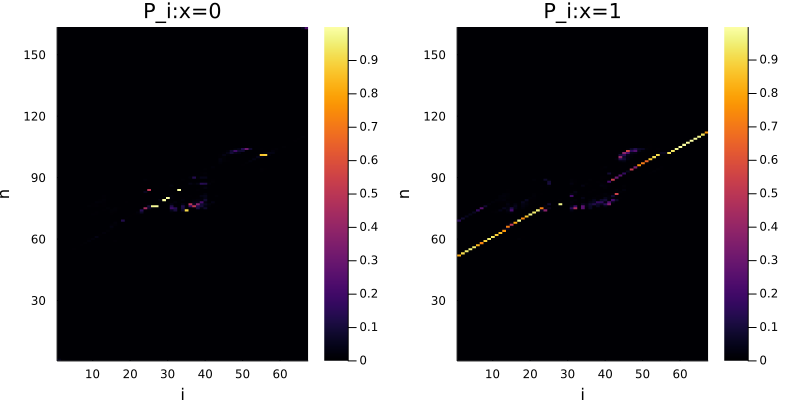

In [34]:
p0 = heatmap(bel_ϵ[:,1,:], xlabel="i", ylabel="n", title="P_i:x=0")
p1 = heatmap(bel_ϵ[:,2,:], xlabel="i", ylabel="n", title="P_i:x=1")
p = plot(p0, p1, size=(800,400))

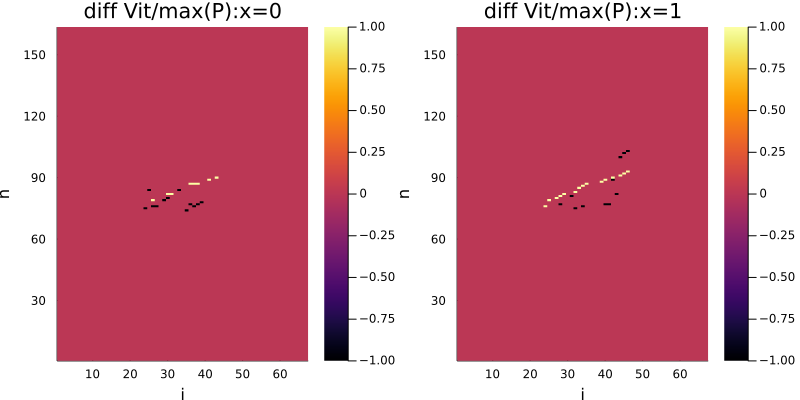

In [35]:
p2 = heatmap(t_vit[:,1,:] .- t_maxP[:,1,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=0")
p3 = heatmap(t_vit[:,2,:] .- t_maxP[:,2,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=1")
plot(p2,p3, size=(800,400))

In [25]:
p00 = heatmap(bel_ϵ[:,1,:] .- bel_0[:,1,:], xlabel="i", ylabel="n", title="Diff ϵ: x=0")
p01 = heatmap(bel_ϵ[:,2,:] .- bel_0[:,2,:], xlabel="i", ylabel="n", title="Diff ϵ: x=1")
p = plot(p00, p01, size=(800,400))

LoadError: UndefVarError: bel_0 not defined

In [34]:
#scatter(bel_0[:], bel_ϵ[:])

# Sampling with Viterbi

In [39]:
ntrials = 100
dists_Vsamps = []
energy_Vsamps = []
xnsols_SAMP = []
for i in 1:ntrials
    xnsol_sampled = BpAlignGpu.viterbi_sampling(af, pm);
    dist = sum(xnsol_vit .!= xnsol_sampled)
    seqsol_samp = BpAlignGpu.convert_soltosequence!(xnsol_sampled, seq.strseq, N, L)
    energy_samp = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_samp[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    append!(dists_Vsamps, dist)
    append!(energy_Vsamps, energy_samp)
    append!(xnsols_SAMP, [xnsol_sampled])
    diffE = energy_samp - energy_vit
    @show dist, diffE
end

(dist, diffE) = (2, 2.9220886f0)
(dist, diffE) = (1, 12.062073f0)
(dist, diffE) = (2, 8.057068f0)
(dist, diffE) = (6, 20.520065f0)
(dist, diffE) = (13, 37.660538f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (6, 10.145081f0)
(dist, diffE) = (4, 15.648422f0)
(dist, diffE) = (3, 19.69664f0)
(dist, diffE) = (2, 5.853836f0)
(dist, diffE) = (2, 8.683151f0)
(dist, diffE) = (1, 1.6371002f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 2.9220886f0)
(dist, diffE) = (1, 1.6371002f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 1.6371002f0)
(dist, diffE) = (4, 20.839432f0)
(dist, diffE) = (4, 15.800507f0)
(dist, diffE) = (2, 2.9220886f0)
(dist, diffE) = (6, 8.86116f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (8, 10.204437f0)
(dist, diffE) = (5, 7.441559f0)
(dist, diffE) = (1, 8.22403f0)
(dist, diffE) = (8, 27.397003f0)
(dist, diffE) = (2, 7.3132324f0)
(dist, diffE) = (3, 18.21518f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (10, 25.971954f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 1

In [40]:
xnsols_SAMP |> unique

61-element Vector{Any}:
 [(1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60)  …  (1, 106), (1, 107), (1, 108), (1, 109), (1, 110), (1, 111), (1, 112), (1, 113), (0, 166), (0, 166)]
 [(1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60)  …  (1, 106), (1, 107), (1, 108), (1, 109), (1, 110), (1, 111), (1, 112), (1, 113), (1, 114), (1, 115)]
 [(1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60)  …  (1, 106), (1, 107), (1, 108), (1, 109), (1, 110), (1, 111), (1, 112), (1, 113), (1, 114), (0, 166)]
 [(1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60)  …  (1, 106), (1, 107), (1, 108), (1, 109), (1, 110), (1, 111), (1, 112), (0, 166), (0, 166), (0, 166)]
 [(1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60)  …  (1, 106), (1, 107), (1, 108), (1, 109), (1, 110), (1, 111), (1, 112), (1, 113), (1, 114), (0, 166)]
 

In [41]:
mean(dists_Vsamps), std(dists_Vsamps)

(3.07, 2.9721094097348337)

In [42]:
mean(energy_Vsamps .- energy_vit), std(energy_Vsamps .- energy_vit)

(9.830683f0, 9.160453f0)

# -------------- Loop over sequences --------------

In [60]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false
xnsol = fill((0, 0), L);
epscoupling=(false, T(0.0), xnsol)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [61]:
#pa.damp = T(0.0)

In [62]:
nsamp=50

betas_seq = []
errs_seq = []
polars_seq = []

check_seq = []
ens_seq = []
ens_nucleation = []
ens_viterbi = []
U_seq = []
S_seq = []

xnsols_seq = fill((0, 0), L, nsamp)
xnsols_nucleation = fill((0, 0), L, nsamp)
xnsols_viterbi = fill((0, 0), L, nsamp)
#bels_seq = zeros(Nmax+2,2,L, nsamp);

In [ ]:
#samps = rand(1:M, nsamp);
samps = readdlm("run_GS_PF00684_n50_mf_maxP.txt");
samps = Int.(samps[2,1:50])

In [63]:
samps

50-element Vector{Int64}:
 20
 81
 59
 78
 79
 38
 48
 55
 48
 90
 99
 15
 61
  ⋮
 31
 34
 37
 22
 45
 46
 28
 11
 51
 80
 68
 56

In [ ]:
#for (i,idx0) in pairs(samps)
#    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
#    N = length(al[idx0][2])
#    @show i, idx0, N
#end    

In [ ]:
iters = 700
minpol = 0.90
nmax = 30
minbet = 0.01

P = fill(fill(0.0, 0:1,0:N+1), L)
for (i,idx0) in pairs(samps)
    @show i, idx0

    #build seq, pm
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    @show seq
    
    #build BP fields
    bpm = BPMessages(seq, pm, pa)
    bpb = BPBeliefs(N, L)
    lrf = LongRangeFields(N, L)
    af = AllFields(bpm, bpb, lrf)
    
    #find ground state
    @time beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet)    

    #decimation using nucleation
    BpAlignGpu.reshape_T3(bel,P)
    s, P = BpAlignGpu.decimate_post(seq, P, L, q, N, false);
    seqsol_nucl = BpAlignGpu.decodeposterior(P, seq.strseq)
    sat = BpAlignGpu.check_assignment(P,false,N)
    if sat == false
        println("problem during nucleation")
        exit(0)
    end
    xnsol_nucl = BpAlignGpu.convertseqtoxnsol(seqsol_nucl, pm)
    energy_nucl = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_nucl[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    
    #decimation using Viterbi
    xnsol_vit, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
    seqsol_vit = BpAlignGpu.convert_soltosequence!(xnsol_vit, seq.strseq, N, L)
    energy_vit = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_vit[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    c = BpAlignGpu.check_sr!(xnsol_vit, L, N)
    if sum(c) > 0
        println("problem during viterbi: new check=", sum(c))
        exit(0)
    end
    
    
    #store betas, convergence errors, energies and minimum polarizations
    append!(betas_seq, beta)
    append!(errs_seq, err)
    append!(polars_seq, polar)
    append!(ens_seq, energy)
    append!(check_seq, check)
    append!(U_seq, U)
    append!(S_seq, S)
    append!(ens_nucleation, energy_nucl)
    append!(ens_viterbi, energy_vit)
    
    #compute solution:
    xnsols_seq[:,i] = xnsol
    xnsols_nucleation[:,i] = xnsol_nucl
    xnsols_viterbi[:,i] = xnsol_vit
    #bels_seq[1:N+2,:,:,i] = bel
    
    println("\n")
end

(i, idx0) = (1, 20)
seq = CEACDGNGAEKGSPEACGTCKGMGQVRMQQ---GFFT--VQQACPTCRGAGKVI--KNPCSKCQGQG
FGDVFGDIFGGGGGRGRNTRGSDLRYTLDLDLEEAVKGRTVKITIPGHRECEACDGNGAEKGSRPEACGTCKGMGQVRMQQGFFTVQQACPTCRGAGKVIKNPCSKCQGQGRVKEEKTLSVKVPPGVDTGDRIRLSGEGEMGIEGGPAGDLYVQMAVREHS
beta = 0.0
converged: err=0.0009338283, tol=0.001, nbiter=5
(polar, energy) = (0.009881129f0, 2262.5608f0)
beta = 0.1


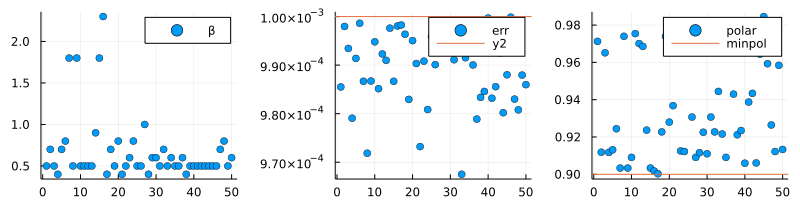

In [43]:
pb = scatter(1:nsamp, betas_seq, label="β")
per = scatter(1:nsamp, errs_seq, label="err")
hline!([pa.tol])
pp = scatter(1:nsamp, polars_seq, label = "polar")
hline!([minpol], label="minpol")
p = plot(pb, per, pp, layout=(1,3), size=(800,200))

In [44]:
ens_seq

50-element Vector{Any}:
 -164.03105f0
 -132.16013f0
 -157.31967f0
 -170.27573f0
 -140.85283f0
 -123.00037f0
 -104.13954f0
 -161.87419f0
 -104.13954f0
 -147.56625f0
 -164.98929f0
 -155.42966f0
 -173.75851f0
    ⋮
 -156.11017f0
 -132.5328f0
 -164.25739f0
 -162.52592f0
 -156.21057f0
 -160.78099f0
 -187.3432f0
 -168.16118f0
 -143.63019f0
 -146.05731f0
 -158.1868f0
 -152.70056f0

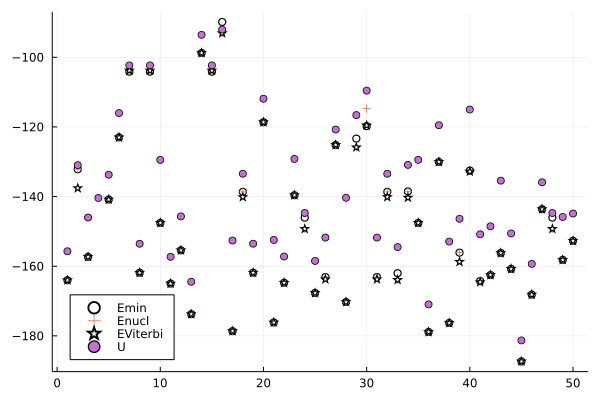

In [45]:
pen = scatter(1:nsamp, ens_seq, label="Emin", m=:circle, c=:white, msw=1.5)
scatter!(1:nsamp, ens_nucleation, label="Enucl", m=:+, msw=1.5)
scatter!(1:nsamp, ens_viterbi, label="EViterbi", m=:star, c=:white, msw=1.5)
scatter!(1:nsamp, U_seq, label="U", legend=:bottomleft)


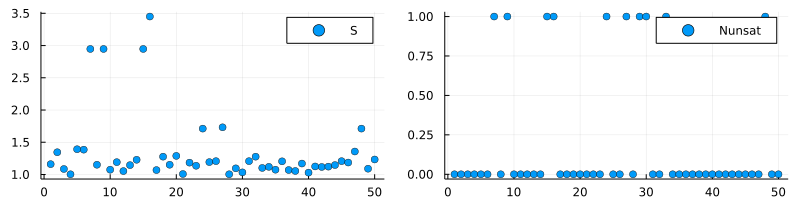

In [46]:
ps = scatter(1:nsamp, S_seq, label="S")
pc = scatter(1:nsamp, check_seq, label="Nunsat")
plot(ps, pc, layout=(1,2), size=(800,200))

In [47]:
n_PmaxgivesSol = sum(check_seq .== 0), findall(check_seq .!= 0)

(40, [7, 9, 15, 16, 24, 27, 29, 30, 33, 48])

In [49]:
findall(ens_nucleation .> ens_seq), findall(ens_viterbi .> ens_seq)

([7, 9, 15, 27, 30], [7, 9, 15, 27, 30])

In [50]:
findall(ens_viterbi .> ens_seq), findall(ens_viterbi .> ens_nucleation)

([7, 9, 15, 27, 30], Int64[])

In [51]:
sum(ens_nucleation .< ens_seq), sum(ens_nucleation .== ens_seq), sum(ens_nucleation .> ens_seq)

(5, 40, 5)

In [52]:
sum(ens_viterbi .< ens_seq), sum(ens_viterbi .== ens_seq), sum(ens_viterbi .> ens_seq)

(15, 30, 5)

In [53]:
sum(ens_viterbi .< ens_nucleation), sum(ens_viterbi .== ens_nucleation), sum(ens_viterbi .> ens_nucleation)

(14, 36, 0)

In [54]:
#using Plots
#i=1
#idx0 = samples[i]
#N = length(al[idx0][2])
#bel = bels_seq[1:N+2,:,:,i];
#p0 = heatmap(bel[:,1,:], xlabel="i", ylabel="n", title="x=0")
#p1 = heatmap(bel[:,2,:], xlabel="i", ylabel="n", title="x=1")
#p = plot(p0, p1, size=(500,250))

In [55]:
paramrun = [nsamp, fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, minpol, nmax, minbet]

14-element Vector{Any}:
  50
    "PF00684"
  67
 100
  50
   0.9f0
   0.001f0
   1.0f-10
    :random
    :mf
 700
   0.9
  30
   0.01

In [56]:
namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*"_maxP.txt"

open(namefile, "a") do io
    writedlm(io, [paramrun])
    writedlm(io, [samps])
end

for (i,idx0) in pairs(samps)
    x0 = [x[1] for x in xnsols_seq[:,i]]
    x1 = [x[2] for x in xnsols_seq[:,i]]
    xc = vcat(x0, x1)
    open(namefile, "a") do io
        writedlm(io, [xc])
    end
end


In [57]:
namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*"_nucleation.txt"

open(namefile, "a") do io
    writedlm(io, [paramrun])
    writedlm(io, [samps])
end

for (i,idx0) in pairs(samps)
    x0 = [x[1] for x in xnsols_nucleation[:,i]]
    x1 = [x[2] for x in xnsols_nucleation[:,i]]
    xc = vcat(x0, x1)
    open(namefile, "a") do io
        writedlm(io, [xc])
    end
end


In [58]:
namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*"_viterbi.txt"

open(namefile, "a") do io
    writedlm(io, [paramrun])
    writedlm(io, [samps])
end

for (i,idx0) in pairs(samps)
    x0 = [x[1] for x in xnsols_viterbi[:,i]]
    x1 = [x[2] for x in xnsols_viterbi[:,i]]
    xc = vcat(x0, x1)
    open(namefile, "a") do io
        writedlm(io, [xc])
    end
end


In [59]:
open("inds.txt", "a") do io
    writedlm(io, [samps])
end

In [59]:
#namefile = "run_GS_"*String(fam)*"_n"*string(nsamp)*"_"*String(pa.lr)*".txt"
#for (i,idx0) in pairs(samps)
#    @show i, idx0

#    #build seq, pm
#    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
#    N = length(al[idx0][2])
#    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
#    seqsol = BpAlignGpu.convert_soltosequence!(xnsols_seq[:,i], seq.strseq, N, L)
#    r = [idx0, seqsol[1], seqsol[2], seqsol[3], seqsol[4]]
#    open(namefile, "a") do io
#               writedlm(io, [r])
#    end
    
#end

# -------------- $\epsilon$ increasing --------------

In [60]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false
xnsol = fill((0, 0), L);
epscoupling=(false, T(0.0), xnsol)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [61]:
#pa.damp = T(0.0)

In [62]:
epsilons = [-0.0, -0.1, -0.2, -0.3,-0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.2]
#epsilons = [-0.0, -0.5, -1.0]

11-element Vector{Float64}:
 -0.0
 -0.1
 -0.2
 -0.3
 -0.4
 -0.5
 -0.6
 -0.7
 -0.8
 -0.9
 -1.2

In [63]:
length(epsilons)

11

In [64]:
betas_seq_eps = zeros(length(epsilons), nsamp)
errs_seq_eps = zeros(length(epsilons), nsamp)
polars_seq_eps = zeros(length(epsilons), nsamp)
ens_seq_eps = zeros(length(epsilons), nsamp)
U_seq_eps = zeros(length(epsilons), nsamp)
S_seq_eps = zeros(length(epsilons), nsamp)
check_seq_eps = zeros(length(epsilons), nsamp)

xnsols_seq_eps = fill((0,0), L, length(epsilons), nsamp);
#bels_seq_eps = ones(Nmax+2,2,L, length(epsilons), nsamp);

In [65]:
iters = 2000

minpol = 0.90
nmax = 30
minbet = 0.02

betamax = 0.5

0.5

In [66]:
samps

50-element Vector{Int64}:
  3975
     4
 26668
 51956
 22511
 59405
 46007
 36064
   750
 26770
  6640
 12681
 17530
     ⋮
  4969
 44511
 31646
 12615
 57928
 49799
 23123
 52161
  3154
 39149
 55411
 30038

In [ ]:
for (i,idx0) in pairs(samps)

    #build seq, pm
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    xn = xnsols_viterbi[:,i] 
    for j in eachindex(epsilons)
        ϵ = epsilons[j]
        @show i, idx0, N, ϵ
        pa.epscoupling = (true, T(ϵ), xn)

        #build BP fields
        bpm = BPMessages(seq, pm, pa)
        bpb = BPBeliefs(N, L)
        lrf = LongRangeFields(N, L)
        af = AllFields(bpm, bpb, lrf)
        
        #@time beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet)
        @time beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS_beta1(af, pm, pa, seq, iters = iters, betamax = betamax)
        
        #decimation using Viterbi
        xnsol, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
        seqsol = BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L)
        energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
        c = BpAlignGpu.check_sr!(xnsol, L, N)
        if sum(c) > 0
            println("problem during viterbi: new check=", sum(c))
            exit(0)
        end
 
        betas_seq_eps[j,i] = beta
        errs_seq_eps[j,i] = err
        polars_seq_eps[j,i] = polar
        ens_seq_eps[j,i] = energy
        U_seq_eps[j,i] = U
        S_seq_eps[j,i] = S
        check_seq_eps[j,i] = check

        #bels_seq_eps[1:N+2, :, :, j, i] = bel
        xnsols_seq_eps[:,j,i] = xnsol
        @show i, idx0, ϵ, energy, U
        println("\n")
    end
    println("\n")
end


(i, idx0, N, ϵ) = (1, 3975, 40, -0.0)
beta = 0.0
converged: err=0.0009910986, tol=0.001, nbiter=57
beta = 0.05
converged: err=0.0009729415, tol=0.001, nbiter=30
beta = 0.1
converged: err=0.0009934902, tol=0.001, nbiter=32
beta = 0.15
converged: err=0.0009767711, tol=0.001, nbiter=33
beta = 0.2
converged: err=0.0009894371, tol=0.001, nbiter=32
beta = 0.25
converged: err=0.00097087026, tol=0.001, nbiter=31
beta = 0.3
converged: err=0.0009910017, tol=0.001, nbiter=120
beta = 0.35
converged: err=0.0009917617, tol=0.001, nbiter=215
beta = 0.4
converged: err=0.00096029043, tol=0.001, nbiter=174
beta = 0.45
converged: err=0.0009620786, tol=0.001, nbiter=104
beta = 0.5
converged: err=0.0009752512, tol=0.001, nbiter=26
(polar, energy) = (0.96745944f0, -67.76363f0)
 91.882208 seconds (50.08 M allocations: 2.581 GiB, 2.61% gc time, 8.07% compilation time)
(i, idx0, ϵ, energy, U) = (1, 3975, -0.0, -67.76363f0, -62.0152f0)


(i, idx0, N, ϵ) = (1, 3975, 40, -0.1)
beta = 0.0
converged: err=0.00099251

In [169]:
errs_seq_eps
mask_errs = (errs_seq_eps .<0.9)
nb_converged = sum(mask_errs, dims=2)

11×1 Matrix{Int64}:
 50
 50
 50
 50
 50
 50
 50
 50
 50
 50
 50

In [170]:
mask = (check_seq_eps .== 0.0)
nbsol_mean = [mean(mask[j,:]) for j in eachindex(epsilons)]
nbsol_std = [std(mask[j,:]) for j in eachindex(epsilons)]./sqrt(nsamp);
nbsol_mean

11-element Vector{Float64}:
 0.92
 0.92
 0.92
 0.92
 0.94
 0.88
 0.8
 0.7
 0.68
 0.54
 0.26

In [171]:
findall( [!(xnsols_viterbi[:,i] == xnsols_seq_eps[:,1,i]) for i in 1:nsamp])

Int64[]

In [177]:
mΔEs = []
vΔEs = []
mΔUs = []
vΔUs = []
mΔdist = []
vΔdist = []
for j in eachindex(epsilons)
    ΔE = []
    ΔU = []
    Δi = []
    for i in 1:nsamp
        if mask_errs[j,i]
            dE = (ens_seq_eps[j,i] - ens_seq_eps[1,i])
            append!(ΔE, dE)
            dU = (U_seq_eps[j,i] - U_seq_eps[1,i])
            append!(ΔU, dU)
            di = sum(xnsols_seq_eps[:,j,i] .!= xnsols_seq_eps[:,1,i])/L
            append!(Δi, di)
        end
    end
    append!(mΔEs, mean(ΔE))
    append!(vΔEs, std(ΔE)/sqrt(nb_converged[j]))
    append!(mΔUs, mean(ΔU))
    append!(vΔUs, std(ΔU)/sqrt(nb_converged[j]))
    append!(mΔdist, mean(Δi))
    append!(vΔdist, std(Δi)/sqrt(nb_converged[j]))
end

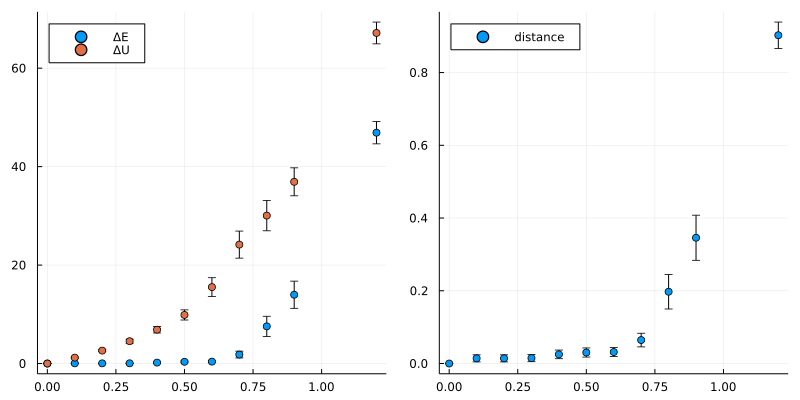

In [178]:
pΔ = scatter(-epsilons, mΔEs, yerr=vΔEs, label="ΔE", legend=:topleft)
scatter!(-epsilons, mΔUs, yerr=vΔUs, label="ΔU")
pdist = scatter(-epsilons, mΔdist, yerr=vΔdist, label="distance", legend=:topleft)
plot(pΔ, pdist, size=(800,400))

In [179]:
mE = []
vE = []
mU = []
vU = []
mS = []
vS = []
for j in eachindex(epsilons)
    EE = []
    UU = []
    SS = []
    for i in 1:nsamp
        if mask_errs[j,i]
            append!(EE, ens_seq_eps[j,i])
            append!(UU, U_seq_eps[j,i])
            append!(SS, S_seq_eps[j,i])
        end
    end
    append!(mE, mean(EE))
    append!(vE, std(EE)/sqrt(nb_converged[j]))
    append!(mU, mean(UU))
    append!(vU, std(UU)/sqrt(nb_converged[j]))
    append!(mS, mean(SS))
    append!(vS, std(SS)/sqrt(nb_converged[j]))
end

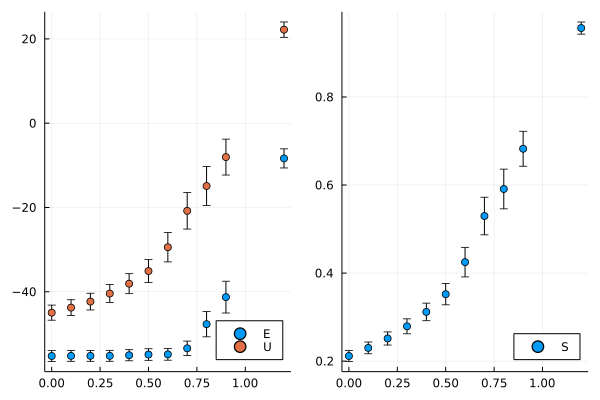

In [180]:
pu = scatter(-epsilons, mE, yerr=vE, label="E", legend=:bottomright)
scatter!(-epsilons, mU, yerr=vU, label="U", legend=:bottomright)
ps = scatter(-epsilons, mS, yerr=vS, label="S", legend=:bottomright)
plot(pu, ps)

In [83]:
exp(L*0.8)

5.895262545980225e10

In [181]:
μbetas = [mean(betas_seq_eps[j,:]) for j in eachindex(epsilons)]
σbetas = [std(betas_seq_eps[j,:]) for j in eachindex(epsilons)]./sqrt(nsamp)
μerrs = [mean(errs_seq_eps[j,:]) for j in eachindex(epsilons)]
σerrs = [std(errs_seq_eps[j,:]) for j in eachindex(epsilons)]./sqrt(nsamp);

In [182]:
mpolars = []
vpolars = []
for j in eachindex(epsilons)
    pols = []
    for i in 1:nsamp
        if mask_errs[j,i]
            append!(pols, polars_seq_eps[j,i])
        end
    end
    append!(mpolars, mean(pols))
    append!(vpolars, std(pols)/sqrt(nb_converged[j]))
end

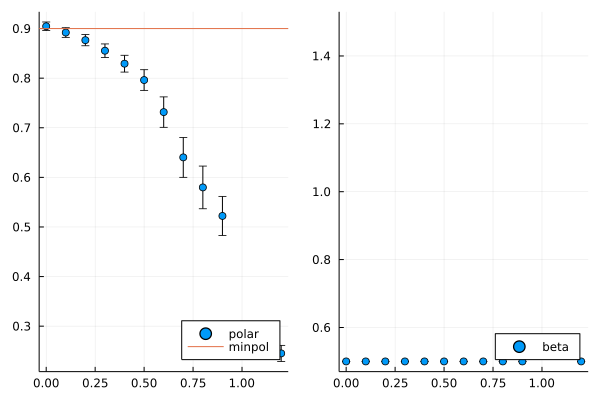

In [183]:
pp = scatter(-epsilons, mpolars, yerr=vpolars, label="polar", legend=:bottomright)
hline!([minpol], label="minpol")
pb = scatter(-epsilons, μbetas, yerr=σbetas, label="beta", legend=:bottomright)
plot(pp, pb)

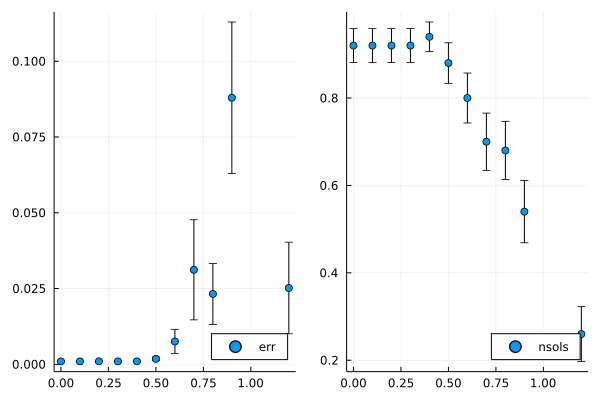

In [184]:
pe = scatter(-epsilons, μerrs, yerr=σerrs, label="err", legend=:bottomright)
pnunsat = scatter(-epsilons, nbsol_mean, yerr=nbsol_std, label="nsols", legend=:bottomright)
plot(pe, pnunsat)

In [166]:
paramrun = [nsamp, fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, betamax]
#paramrun = [nsamp, fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, minpol, nmax, minbet]

12-element Vector{Any}:
    50
      "PF00397"
    31
 59696
     5
     0.9f0
     0.001f0
     1.0f-10
      :random
      :sce
  2000
     0.5

In [188]:
namefile

"run_epsilon_PF00397_sce_50_betafixed.txt"

In [187]:
namefile = "run_epsilon_"*String(fam)*"_"*String(pa.lr)*"_"*string(nsamp)*"_betafixed.txt"
open(namefile, "a") do io
    writedlm(io, [paramrun])
end

open(namefile, "a") do io
    writedlm(io, [epsilons])

    writedlm(io, [mΔEs])
    writedlm(io, [vΔEs])
    writedlm(io, [mΔUs])
    writedlm(io, [vΔUs])
    writedlm(io, [mΔdist])
    writedlm(io, [vΔdist])
    
    writedlm(io, [mE])
    writedlm(io, [vE])
    writedlm(io, [mU])
    writedlm(io, [vU])
    writedlm(io, [mS])
    writedlm(io, [vS])
    
    writedlm(io, [mpolars])
    writedlm(io, [vpolars])
    writedlm(io, [μbetas])
    writedlm(io, [σbetas])
    writedlm(io, [μerrs])
    writedlm(io, [σerrs])

    writedlm(io, [nbsol_mean])
    writedlm(io, [nbsol_std])
end
